In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.morphology import iterate_structure

from typing import Tuple, Callable, List


from pathlib import Path
import librosa

from IPython.display import Audio

%matplotlib inline

In [2]:
local_song_path = r"C:\Users\caden\Programming\bwsi\ryan-sus\audio\data\champagne.mp3"

duration = 5

# load the digital signal for the first 11 seconds of the song
recorded_audio, sampling_rate = librosa.load(local_song_path, sr=44100, mono=True, duration=duration)

c:\anaconda3\envs\week1\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [3]:
Audio(recorded_audio, rate=sampling_rate)

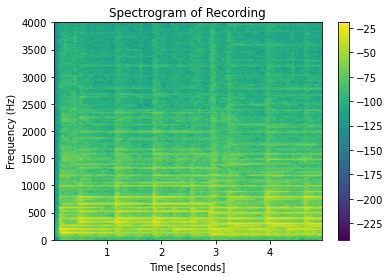

In [4]:
# using matplotlib's built-in spectrogram function
import matplotlib.mlab as mlab

fig, ax = plt.subplots()

spectrogram, freqs, times, im = ax.specgram(
    recorded_audio,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
    mode='magnitude',
    scale="dB"
)
fig.colorbar(im)

ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Recording")
ax.set_ylim(0, 4000);

In [5]:
from numba import njit

# `@njit` "decorates" the `_peaks` function. This tells Numba to
# compile this function using the "low level virtual machine" (LLVM)
# compiler. The resulting object is a Python function that, when called,
# executes optimized machine code instead of the Python code
# 
# The code used in _peaks adheres strictly to the subset of Python and
# NumPy that is supported by Numba's jit. This is a requirement in order
# for Numba to know how to compile this function to more efficient
# instructions for the machine to execute
@njit
def _peaks(
    data_2d: np.ndarray, nbrhd_row_offsets: np.ndarray, nbrhd_col_offsets: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    nbrhd_row_offsets : numpy.ndarray, shape-(N,)
        The row-index offsets used to traverse the local neighborhood.
        
        E.g., given the row/col-offsets (dr, dc), the element at 
        index (r+dr, c+dc) will reside in the neighborhood centered at (r, c).
    
    nbrhd_col_offsets : numpy.ndarray, shape-(N,)
        The col-index offsets used to traverse the local neighborhood. See
        `nbrhd_row_offsets` for more details.
        
    amp_min : float
        All amplitudes equal to or below this value are excluded from being
        local peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned in 
        column-major order
    """
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterating over each element in the the 2-D data 
    # in column-major ordering
    #
    # We want to see if there is a local peak located at
    # row=r, col=c
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c) to see
        # if (r, c) is associated with the largest value in that
        # neighborhood.
        #
        # dr: offset from r to visit neighbor
        # dc: offset from c to visit neighbor
        for dr, dc in zip(nbrhd_row_offsets, nbrhd_col_offsets):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary.. skip!
                continue

            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary.. skip!
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a local peak
            peaks.append((r, c))
    return peaks

# `local_peak_locations` is responsible for taking in the boolean mask `neighborhood`
# and converting it to a form that can be used by `_peaks`. This "outer" code is 
# not compatible with Numba which is why we end up using two functions:
# `local_peak_locations` does some initial pre-processing that is not compatible with
# Numba, and then it calls `_peaks` which contains all of the jit-compatible code
def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    
    Notes
    -----
    The local peaks are returned in column-major order, meaning that we 
    iterate over all nbrhd_row_offsets in a given column of `data_2d` in search for
    local peaks, and then move to the next column.
    """

    # We always want our neighborhood to have an odd number
    # of nbrhd_row_offsets and nbrhd_col_offsets so that it has a distinct center element
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1
    
    # Find the indices of the 2D neighborhood where the 
    # values were `True`
    #
    # E.g. (row[i], col[i]) stores the row-col index for
    # the ith True value in the neighborhood (going in row-major order)
    nbrhd_row_indices, nbrhd_col_indices = np.where(neighborhood)
    

    # Shift the neighbor indices so that the center element resides 
    # at coordinate (0, 0) and that the center's neighbors are represented
    # by "offsets" from this center element.
    #
    # E.g., the neighbor above the center will has the offset (-1, 0), and 
    # the neighbor to the right of the center will have the offset (0, 1).
    nbrhd_row_offsets = nbrhd_row_indices - neighborhood.shape[0] // 2
    nbrhd_col_offsets = nbrhd_col_indices - neighborhood.shape[1] // 2

    return _peaks(data_2d, nbrhd_row_offsets, nbrhd_col_offsets, amp_min=amp_min)

In [6]:
def local_peaks_mask(data: np.ndarray, cutoff: float) -> np.ndarray:
    """Find local peaks in a 2D array of data and return a 2D array
    that is 1 wherever there is a peak and 0 where there is not.

    Parameters
    ----------
    data : numpy.ndarray, shape-(H, W)

    cutoff : float
         A threshold value that distinguishes background from foreground

    Returns
    -------
    Binary indicator, of the same shape as `data`. The value of
    1 indicates a local peak."""
    # Generate a rank-2, connectivity-2 neighborhood array
    # We will not use `iterate_structure` in this example
    neighborhood_array = generate_binary_structure(2, 2)  # <COGSTUB>

    # Use that neighborhood to find the local peaks in `data`.
    # Pass `cutoff` as `amp_min` to `local_peak_locations`.
    peak_locations = local_peak_locations(data, neighborhood_array, cutoff)  # <COGSTUB>

    # Turns the list of (row, col) peak locations into a shape-(N_peak, 2) array
    # Save the result to the variable `peak_locations`
    peak_locations = np.array(peak_locations)

    # create a boolean mask of zeros with the same shape as `data`
    mask = np.zeros(data.shape, dtype=bool)

    # populate the local peaks with `1`
    mask[peak_locations[:, 0], peak_locations[:, 1]] = 1
    return mask

In [7]:
def plot_compare(
    data: np.ndarray,
    peak_rendering_func: Callable[[np.ndarray], np.ndarray],
    cutoff: float = -np.inf,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the original data side-by-side with the binary indicator
    for the local peaks.

    Parameters
    ----------
    data : numpy.ndarray, shape=(N, H, W)
        N 2D arrays of shape (H, W)

    peak_finding_function : Callable[[ndarray], ndarray]
        A function that will locate the 2D peaks in `data` and
        create an image with the 2D peaks 

    cutoff : float, optional (default=-np.inf)
         A threshold value that distinguishes background from foreground
         
    Returns
    -------
    Tuple[matplotlib.Figure, matplotlib.Axes]
        The figure and axes objects of the plot
    """
    fig, ax = plt.subplots()
    ax.imshow(data)
    return fig, ax

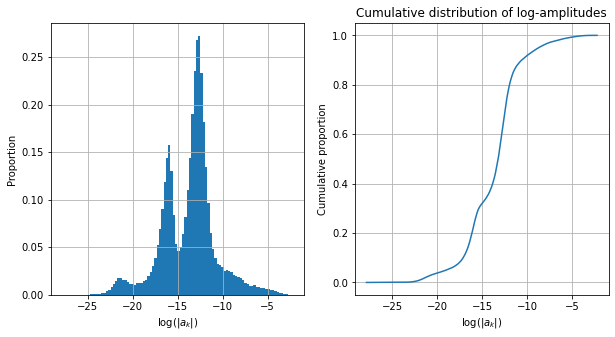

In [8]:
import numpy as np

def ecdf(data):
    """Returns (x) the sorted data and (y) the empirical cumulative-proportion
    of each datum.
    
    Parameters
    ----------
    data : numpy.ndarray, size-N
    
    Returns
    -------
    Tuple[numpy.ndarray shape-(N,), numpy.ndarray shape-(N,)]
        Sorted data, empirical CDF values"""
    data = np.asarray(data).ravel()  # flattens the data
    y = np.linspace(1 / len(data), 1, len(data))  # stores the cumulative proportion associated with each sorted datum
    x = np.sort(data)
    return x, y


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))


ax1.hist(np.log(spectrogram).ravel(), bins=100, density=True)
ax1.set_xlabel(r"$\log(|a_{k}|)$")
ax1.set_ylabel(r"Proportion")
ax1.grid()

x, y = ecdf(np.log(spectrogram))
ax2.plot(x, y)

ax2.set_xlabel(r"$\log(|a_{k}|)$")
ax2.set_ylabel(r"Cumulative proportion")
ax2.set_title("Cumulative distribution of log-amplitudes")
ax2.grid(True)

In [17]:
log_S = spectrogram.ravel()  # ravel flattens 2D spectrogram into a 1D array
ind = round(len(log_S) * 0.6)  # find the index associated with the 60th percentile log-amplitude
cutoff_log_amplitude = np.partition(log_S, ind)[ind]  # find the actual 60th percentile log-amplitude

In [18]:
cutoff_log_amplitude

2.7218798142723943e-06

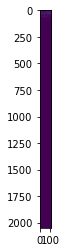

In [19]:
plot_compare(spectrogram, local_peaks_mask, cutoff=cutoff_log_amplitude); # <COGLINE>